### Description
- Investigate prediction differences between labels at time 0 and 24hr
- Only 318 observations with differences >= 0.3

Check
1. Diagnosis
2. Medications
3. Vital trend
4. Lab trend, esp. glucose
5. ADT trajectories, team (Tiffany)
6. Demographics (Tiffany)
7.


Inputs: all from 3.1_notebook
- `1_4_cohort_diff_full_features`: under modeldir4
    - feature_type with the first letter capitalized is for order counts such as Lab
    - feature_type with all lowercase is for actual values: demo, vitals, and labs
    - gender = 1 is for female
- `1_4_cohort_test_results`: under modeldir4
- `1_4_cohort_full_features`: under featuredir, all cohort with all features

In [1]:
library(caret) # import this before glmnet to avoid rlang version problem
library(data.table)
library(tidyverse)
library(lubridate)
library(Matrix)
library(glmnet)
library(bit64)
library(pROC)
library(rms)

Loading required package: lattice

Loading required package: ggplot2

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x purrr::lift()      masks caret::lift()
x purrr::transpose() masks data.table::transpose()


Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'Matrix'


The following 

In [65]:
# directories
datadir = "../../DataTD"
cohortdir = "../../OutputTD/1_cohort"
featuredir = "../../OutputTD/2_features"
modeldir4 = "../../OutputTD/3_models/1_4_cohort"

# display rows and cols
options(repr.matrix.max.rows=250, repr.matrix.max.cols=30)

In [17]:
coh_diff <- read.csv(file.path(modeldir4, '1_4_cohort_diff_full_features.csv'))
nrow(coh_diff) #71107
coh_diff <-  coh_diff %>% mutate(admit_time = ymd_hms(admit_time), time =  ymd_hms(time))
colnames(coh_diff)

coh_diff %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

[1] 71107

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time"              "first_label"            
 [5] "death_24hr_recent_label" "death_24hr_max_label"   
 [7] "pred_first"              "pred_death_24hr_recent" 
 [9] "abs_diff0_24"            "diff0_True"             
[11] "diff24_True"             "feature_type"           
[13] "features"                "values"                 
[15] "time"

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
Microbiology,203
Procedures,513
Imaging,1822
demo,5406
Lab,6305
vitals,12376
Meds,12397
labs,12616
Diagnosis,19469


Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



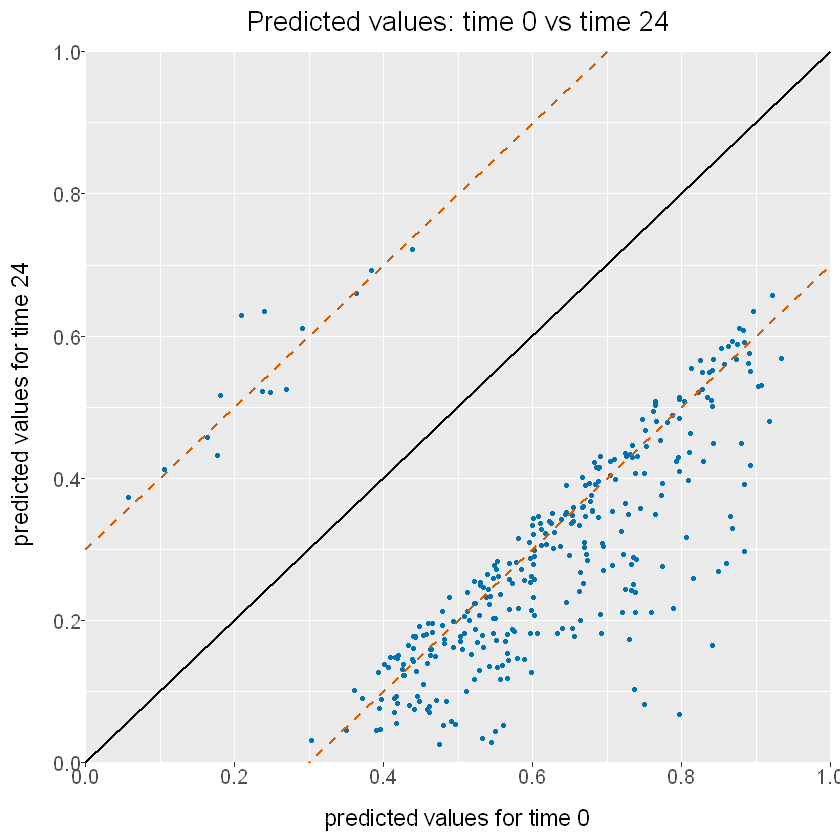

In [18]:
options(repr.plot.width=7, repr.plot.height=7)

ggplot(coh_diff, aes(x=pred_first, y=pred_death_24hr_recent)) + 
    geom_point(color = "#0072B2", size = 1) + xlim(0,1) + ylim(0,1) +
    geom_abline(intercept = 0, slope = 1, size = 0.7) +
    geom_abline(intercept = 0.3, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
    geom_abline(intercept = -0.3, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
    scale_x_continuous(name = "predicted values for time 0", expand = c(0, 0), limits=c(0, 1), 
                       breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) + 
    scale_y_continuous(name = " predicted values for time 24", expand = c(0, 0), limits=c(0, 1), 
                       breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) +
    theme(axis.text=element_text(size=12),
          axis.text.x = element_text(margin=margin(0, 0, 10, 0)),
          axis.text.y = element_text(margin=margin(0, 0, 0, 10)),
          plot.title = element_text(size=16, hjust=0.5, margin=margin(0, 0, 10, 0)),
          axis.title=element_text(size=14)) +
     labs(title = "Predicted values: time 0 vs time 24")


### Check most difference first
- 0.7 or more: 3
- 0.6 or more: 11
- 0.5 or more: 33

These observations include those who transferred and those who didn't.

Difference scenarios:
- 1st label != 24hr label: (transfers)
    - both predicted correctly or close enough
    - one wrong and one right
- 1st label == 24hr label: (same)
    - both predicted correctly or close enough
    - one wrong and one right
    
With the intention to check `model output differences`, all of the read-in data: 
- there is a huge difference btwn the 2 predicted outputs
- regardless whether 1st label != or == 24hr label

With the intention to investigate those who transferred, we are interested in the subgroup where *1st label != 24hr label*

Note that the same model architecture was used with 2 different labels. Binary threshold from the triage paper was 0.6

In [80]:
# count features and csn
diff <- coh_diff %>% 
            group_by(abs_diff0_24) %>% 
            summarise(nrows = n(), count_csn = n_distinct(pat_enc_csn_id_coded), count_mrn = n_distinct(anon_id)) %>% 
            arrange(-abs_diff0_24) %>% mutate(cum_csn = cumsum(count_csn))

diff

`summarise()` ungrouping output (override with `.groups` argument)



abs_diff0_24,nrows,count_csn,count_mrn,cum_csn
<dbl>,<int>,<int>,<int>,<int>
0.7,561,3,3,3
0.6,1328,8,8,11
0.5,5297,22,19,33
0.4,19987,79,76,112
0.3,43934,206,204,318


### Check those with diff >= 0.5 first:
to get some insight before expanding 

In [82]:
d05 <- coh_diff %>% filter(abs_diff0_24 >= 0.5)
length(unique(d05$pat_enc_csn_id_coded))
length(unique(d05$anon_id))
nrow(d05)
colnames(d05)

[1] 33

[1] 29

[1] 7186

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time"              "first_label"            
 [5] "death_24hr_recent_label" "death_24hr_max_label"   
 [7] "pred_first"              "pred_death_24hr_recent" 
 [9] "abs_diff0_24"            "diff0_True"             
[11] "diff24_True"             "feature_type"           
[13] "features"                "values"                 
[15] "time"

### top CSNs
- top 3 (diff >= 0.7): 131276655148, 131271804263, 131265379414
- next 8 (diff >= 0.6 and < 0.7): 131287638900, 131285560953, 131283367768, 131283156969, 131275893768, 131275001383, 131273666433, 131273021618

In [83]:
# top 3 csn
# as.list(distinct(coh_diff %>% filter(abs_diff0_24 >= 0.7) %>% select(pat_enc_csn_id_coded)) %>% arrange(-pat_enc_csn_id_coded))
csn3 <- sort(unique(coh_diff[coh_diff$abs_diff0_24 >= 0.7, ]$pat_enc_csn_id_coded))
csn3

# next 8 csn
csn8 <- sort(unique(coh_diff[coh_diff$abs_diff0_24 >= 0.6 &  coh_diff$abs_diff0_24 < 0.7, ]$pat_enc_csn_id_coded))
csn8

[1] 131265379414 131271804263 131276655148

[1] 131273021618 131273666433 131275001383 131275893768 131283156969
[6] 131283367768 131285560953 131287638900

In [89]:
top3 <- d05 %>% filter(pat_enc_csn_id_coded %in% csn3)
nrow(top3)

top3 %>% group_by(anon_id, pat_enc_csn_id_coded) %>% summarise(n=n())
top3 %>% group_by(pat_enc_csn_id_coded) %>% select(first_label, death_24hr_recent_label,
                                                   pred_first, pred_death_24hr_recent)%>% distinct()

[1] 561

`summarise()` regrouping output by 'anon_id' (override with `.groups` argument)



anon_id,pat_enc_csn_id_coded,n
<chr>,<dbl>,<int>
JCd1a421,131265379414,109
JCd91ab7,131271804263,236
JCe6286a,131276655148,216


Adding missing grouping variables: `pat_enc_csn_id_coded`



pat_enc_csn_id_coded,first_label,death_24hr_recent_label,pred_first,pred_death_24hr_recent
<dbl>,<int>,<int>,<dbl>,<dbl>
131276655148,1,0,0.7492048,0.08195348
131271804263,1,0,0.8406619,0.16503982
131265379414,1,1,0.7969050,0.06790455


### Check how many were transfered:
- 20 out of 33, all are from ICUs to non-ICUs
- all seem correct predictions
- anon_id `JCd91ab7` appeared 3 times
- anon_id `JCe67809` appeared 2 times

In [101]:
nrow(d05 %>% filter(first_label != death_24hr_recent_label) %>% distinct(anon_id))

d05 %>% filter(first_label != death_24hr_recent_label) %>% 
            select(anon_id, pat_enc_csn_id_coded, admit_time, first_label, death_24hr_recent_label, 
                   abs_diff0_24, pred_first, pred_death_24hr_recent) %>%
            arrange(anon_id, pat_enc_csn_id_coded) %>% distinct()# -abs_diff0_24, 

[1] 17

anon_id,pat_enc_csn_id_coded,admit_time,first_label,death_24hr_recent_label,abs_diff0_24,pred_first,pred_death_24hr_recent
<chr>,<dbl>,<dttm>,<int>,<int>,<dbl>,<dbl>,<dbl>
JC2a1b145,131267727359,2019-04-20 13:19:00,1,0,0.5,0.8925185,0.41847357
JC2a31a2b,131273021618,2019-07-01 07:21:00,1,0,0.6,0.8841977,0.29646083
JCcc6f5a,131261651290,2019-01-27 21:31:00,1,0,0.5,0.7241807,0.24340748
JCceb298,131285560953,2020-03-06 04:21:00,1,0,0.6,0.7893417,0.21697571
JCcf7ee2,131261541119,2019-01-15 06:59:00,1,0,0.5,0.8834838,0.39151948
JCd2b078,131281836013,2020-02-05 06:40:00,1,0,0.5,0.6533526,0.18836503
JCd3262e,131275001383,2019-08-15 16:54:00,1,0,0.6,0.8597781,0.27967762
JCd91ab7,131271804263,2019-07-11 21:43:00,1,0,0.7,0.8406619,0.16503982
JCd91ab7,131276678530,2019-10-10 03:52:00,1,0,0.5,0.7376401,0.21183136


### Those who did not transfer:
- 13 (out of 33)
- one label prediction is wrong: 8 are for the 24hr label, 4 for time 0 label and 1 is ambigous (JCe8eecd)
- for those with (0,0) labels at time 0 and 24, only JCe8eecd has max label of 1 (JCe8eecd transfered to ICUs within 24hrs)
- anon_id JC2a1b3e1 appeared 2 times

In [105]:
nrow(d05 %>% filter(first_label == death_24hr_recent_label) %>% distinct(anon_id))

d05 %>% filter(first_label == death_24hr_recent_label) %>% 
            select(anon_id, pat_enc_csn_id_coded, admit_time, first_label, death_24hr_recent_label, death_24hr_max_label,
                   abs_diff0_24, pred_first, pred_death_24hr_recent) %>%
            arrange(-abs_diff0_24, anon_id, pat_enc_csn_id_coded) %>% distinct()

[1] 12

anon_id,pat_enc_csn_id_coded,admit_time,first_label,death_24hr_recent_label,death_24hr_max_label,abs_diff0_24,pred_first,pred_death_24hr_recent
<chr>,<dbl>,<dttm>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
JCd1a421,131265379414,2019-03-21 13:11:00,1,1,1,0.7,0.7969050,0.06790455
JC29fe5a7,131273666433,2019-07-17 11:48:00,1,1,1,0.6,0.7369563,0.10290046
JC2a126ab,131275893768,2019-09-04 05:58:00,0,0,0,0.6,0.8152507,0.25902901
JCe8eecd,131287638900,2020-03-29 06:00:00,0,0,1,0.6,0.7590947,0.21166600
JC29f8e61,131265730309,2019-04-17 22:32:00,1,1,1,0.5,0.6918880,0.18118481
JC29fd236,131264662955,2019-02-11 11:54:00,0,0,0,0.5,0.6906416,0.20826471
JC2a1b3e1,131266865289,2019-03-30 17:11:00,0,0,0,0.5,0.8686259,0.32946409
JC2a1b3e1,131271401201,2019-06-03 17:42:00,0,0,0,0.5,0.8650639,0.34595124
JCd1ef38,131279807307,2019-11-19 03:56:00,0,0,0,0.5,0.8066095,0.31641917


In [146]:
results05 <- d05 %>% select(anon_id, pat_enc_csn_id_coded, admit_time, first_label, death_24hr_recent_label,
                            abs_diff0_24, feature_type, features, values, time) %>% 
                    mutate(transfer = ifelse(first_label != death_24hr_recent_label, 1, 0),
                           hr_before_admit = round(as.numeric(difftime(admit_time, time, unit="hours")), 1)) %>%
                    arrange(anon_id, admit_time, -abs_diff0_24)

In [123]:
results05 %>% filter(transfer==0) %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
results05 %>% filter(transfer==0) %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% top_n(20)

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
Diagnosis,1130
Meds,689
labs,500
vitals,448
Lab,297
demo,221
Imaging,62
Procedures,25
Microbiology,2


`summarise()` ungrouping output (override with `.groups` argument)

Selecting by n



features,n
<chr>,<int>
DBP,106
RR,106
SBP,106
Pulse,98
Temp,32
Glucose,26
Hct,19
Hgb,19
K,17


In [125]:
results05 %>% filter(transfer==1) %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
results05 %>% filter(transfer==1) %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% top_n(20)

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
Diagnosis,975
labs,932
vitals,606
Meds,598
demo,340
Lab,305
Imaging,40
Procedures,13
Microbiology,3


`summarise()` ungrouping output (override with `.groups` argument)

Selecting by n



features,n
<chr>,<int>
Pulse,142
DBP,140
SBP,140
RR,132
Glucose,66
Temp,52
K,43
Na,40
Hct,35


In [121]:
results05 %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
results05 %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% top_n(20)

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
Diagnosis,2105
labs,1432
Meds,1287
vitals,1054
Lab,602
demo,561
Imaging,102
Procedures,38
Microbiology,5


`summarise()` ungrouping output (override with `.groups` argument)

Selecting by n



features,n
<chr>,<int>
DBP,246
SBP,246
Pulse,240
RR,238
Glucose,92
Temp,84
K,60
Na,57
Hct,54


,anon_id,pat_enc_csn_id_coded,admit_time,first_label,death_24hr_recent_label,abs_diff0_24,feature_type,features,values,time,transfer,hr_before_admit
,<chr>,<dbl>,<dttm>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>
1,JC29f8e61,131265730309,2019-04-17 22:32:00,1,1,0.5,vitals,Temp,37.2,2019-04-17 20:10:00,0,2.4
2,JC29f8e61,131265730309,2019-04-17 22:32:00,1,1,0.5,vitals,DBP,95.0,2019-04-17 20:10:00,0,2.4
3,JC29f8e61,131265730309,2019-04-17 22:32:00,1,1,0.5,vitals,DBP,85.0,2019-04-17 21:00:00,0,1.5
4,JC29f8e61,131265730309,2019-04-17 22:32:00,1,1,0.5,vitals,DBP,73.0,2019-04-17 22:00:00,0,0.5
5,JC29f8e61,131265730309,2019-04-17 22:32:00,1,1,0.5,vitals,Pulse,112.0,2019-04-17 20:10:00,0,2.4
6,JC29f8e61,131265730309,2019-04-17 22:32:00,1,1,0.5,vitals,Pulse,102.0,2019-04-17 21:00:00,0,1.5


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   1.000   1.700   2.131   2.900  11.100    4700 

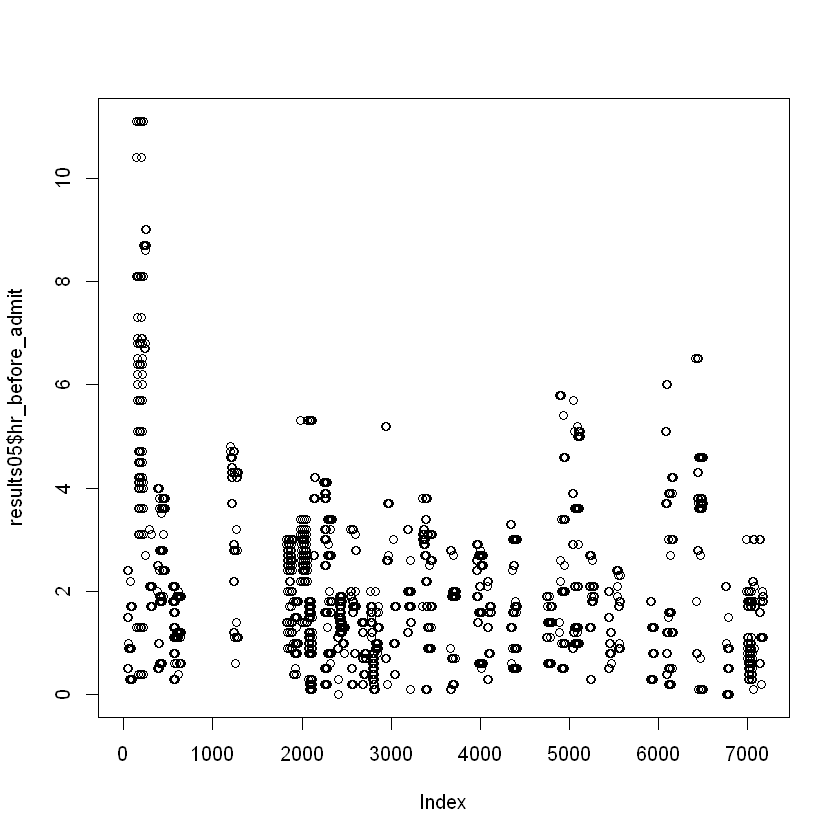

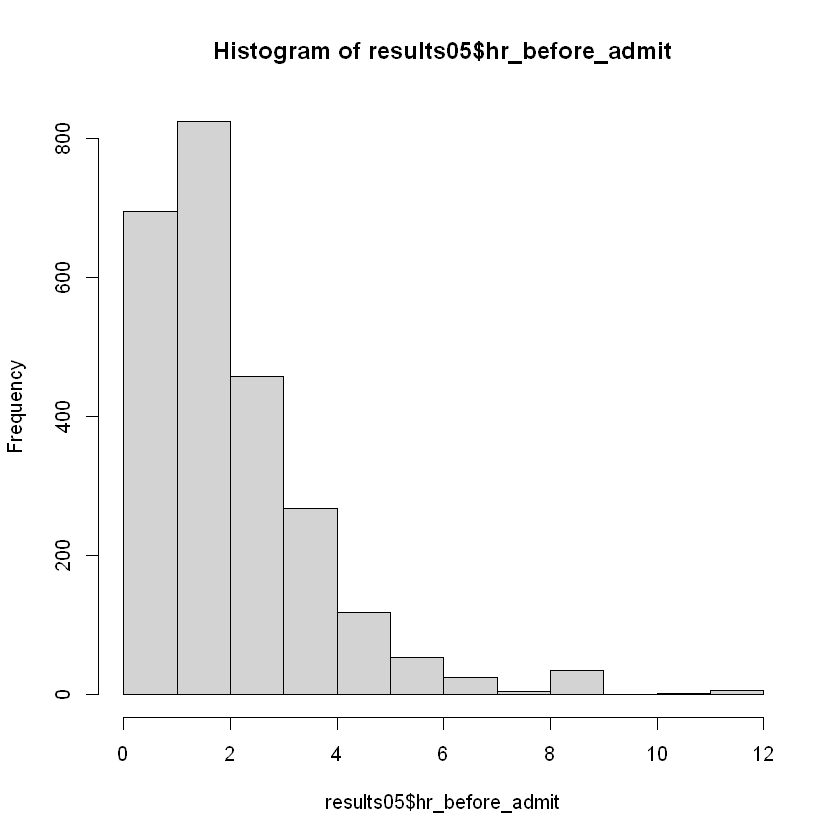

In [150]:
head(results05 %>% filter(feature_type == 'vitals'))
summary(results05$hr_before_admit)
plot(results05$hr_before_admit)
hist(results05$hr_before_admit, breaks=12)

In [223]:
results05_vsglu <- results05 %>% filter(feature_type=='vitals' | features=="Glucose") %>%
                    group_by(pat_enc_csn_id_coded, features, hr_before_admit) %>%
                    summarise(values=mean(values, na.rm=TRUE)) %>%
                    mutate(pat_enc_csn_id_coded = factor(pat_enc_csn_id_coded),
                           features = factor(features))
results05_vsglu %>% group_by(features) %>% summarise(n=n())
head(results05_vsglu)

`summarise()` regrouping output by 'pat_enc_csn_id_coded', 'features' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



features,n
<fct>,<int>
DBP,212
Glucose,87
Pulse,207
RR,206
SBP,212
Temp,44


pat_enc_csn_id_coded,features,hr_before_admit,values
<fct>,<fct>,<dbl>,<dbl>
131261541119,DBP,0.2,60
131261541119,DBP,0.5,77
131261541119,DBP,1.6,72
131261541119,DBP,1.7,72
131261541119,DBP,1.8,70
131261541119,DBP,1.9,68


Warning message:
"`fun.y` is deprecated. Use `fun` instead."
`geom_smooth()` using method = 'loess' and formula 'y ~ x'



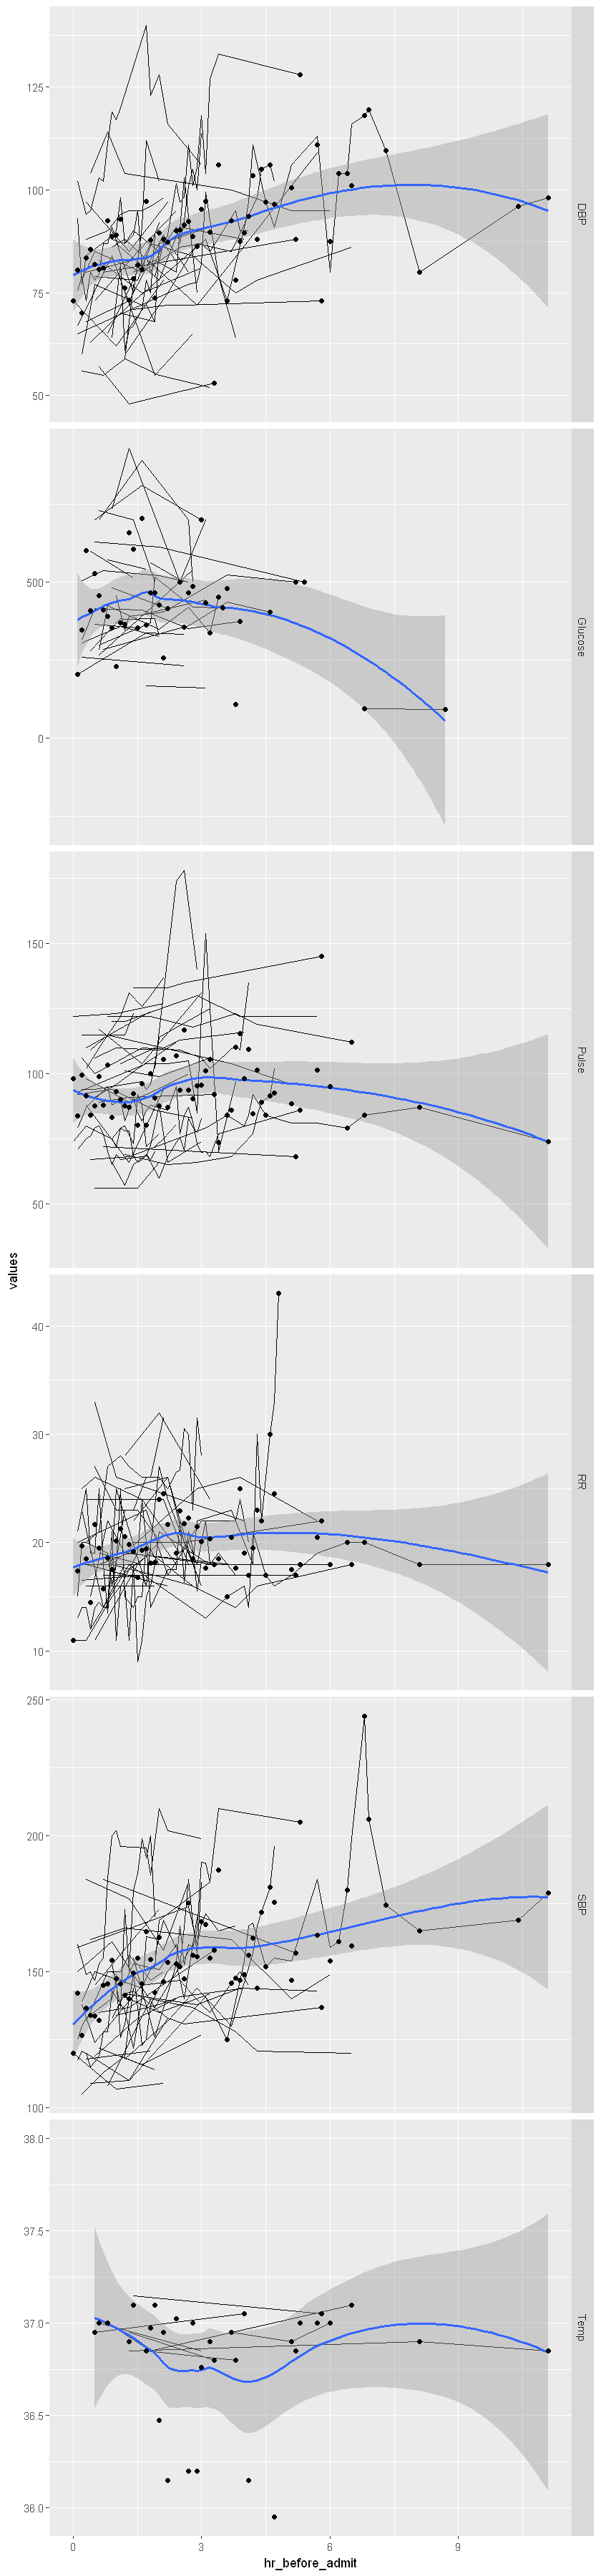

In [224]:
options(repr.plot.width=7, repr.plot.height=30)

# p <- ggplot(data = results05_vs, aes(x = hr_before_admit, y = values, group = pat_enc_csn_id_coded)) + facet_grid(. ~ features)
# facet_wrap(. ~ features, scales="free_y") # cannot do facet_grid with free scale as above
p <- ggplot(data = results05_vsglu, aes(x = hr_before_admit, y = values, group = pat_enc_csn_id_coded)) + facet_grid(features ~ ., scales="free")

# use group 1 as for the whole data NOT per csn: so the smooth is not calculated separately for each csn
p + geom_line() + stat_smooth(aes(group = 1)) + stat_summary(aes(group = 1), geom = "point", fun.y = mean)

In [182]:
results05_vswide <- spread(results05_vs, features, values) %>% 

In [183]:
head(results05_vswide)
summary(results05_vswide)

pat_enc_csn_id_coded,hr_before_admit,DBP,Pulse,RR,SBP,Temp
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
131261541119,0.2,60,94,16.5,139,NA
131261541119,0.5,77,94,NA,150,NA
131261541119,1.6,72,97,17.0,144,NA
131261541119,1.7,72,94,16.0,148,NA
131261541119,1.8,70,96,16.0,151,NA
131261541119,1.9,68,104,18.0,152,NA


   pat_enc_csn_id_coded hr_before_admit       DBP             Pulse       
 131273021618: 25       Min.   : 0.000   Min.   : 48.00   Min.   : 56.00  
 131264662955: 21       1st Qu.: 1.000   1st Qu.: 77.00   1st Qu.: 76.50  
 131279807307: 17       Median : 1.800   Median : 87.00   Median : 89.00  
 131287638900: 15       Mean   : 2.264   Mean   : 87.25   Mean   : 93.35  
 131271401201: 13       3rd Qu.: 3.000   3rd Qu.: 97.00   3rd Qu.:109.00  
 131285560953: 12       Max.   :11.100   Max.   :140.00   Max.   :178.00  
 (Other)     :124                        NA's   :15       NA's   :20      
       RR             SBP             Temp      
 Min.   : 9.00   Min.   :105.0   Min.   :35.95  
 1st Qu.:16.00   1st Qu.:135.0   1st Qu.:36.84  
 Median :18.17   Median :150.0   Median :36.90  
 Mean   :19.76   Mean   :151.7   Mean   :36.83  
 3rd Qu.:23.00   3rd Qu.:167.0   3rd Qu.:37.00  
 Max.   :43.00   Max.   :244.0   Max.   :38.00  
 NA's   :21      NA's   :15      NA's   :183    

Warning message:
"Removed 4 row(s) containing missing values (geom_path)."


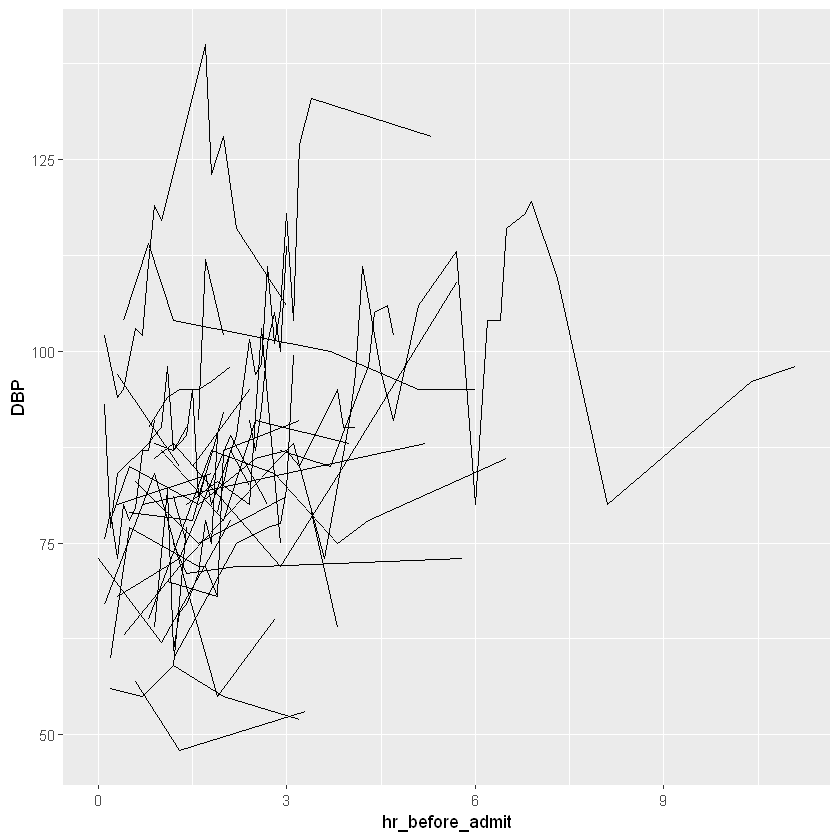

In [186]:
p <- ggplot(data = results05_vswide, aes(x = hr_before_admit, y = DBP, group = pat_enc_csn_id_coded))
p + geom_line()

### First obs:
- CSN: 131265379414
- first_label = death_24hr_recent_label = 1
- pred_first = 0.796905; pred_death_24hr_recent = 0.06790455

In [113]:
# first one: first_label, 24 are both 1
results05 %>% filter(pat_enc_csn_id_coded == 131265379414) %>% select(admit_time, feature_type, features, values, time)

admit_time,feature_type,features,values,time
<dttm>,<chr>,<chr>,<dbl>,<dttm>
2019-03-21 13:11:00,Meds,METOCLOPRAMIDE HCL 5 MG/ML INJ SOLN,1.00,NA
2019-03-21 13:11:00,Lab,"CREATINE KINASE, TOTAL",2.00,NA
2019-03-21 13:11:00,Diagnosis,F41.9,1.00,NA
2019-03-21 13:11:00,Lab,LIPASE,2.00,NA
2019-03-21 13:11:00,Lab,"OSMOLALITY, SERUM",2.00,NA
2019-03-21 13:11:00,Diagnosis,E10.65,1.00,NA
2019-03-21 13:11:00,Meds,INSULIN REGULAR 1 UNIT/ML IV INFUSION DKA/HHS (VC),1.00,NA
2019-03-21 13:11:00,Meds,LACTATED RINGERS IV BOLUS,1.00,NA
2019-03-21 13:11:00,Lab,"T4, FREE",3.00,NA


### Investigate:
1. Diagnosis
2. Medications
3. Vital trend
4. Lab trend, esp. glucose
5. ADT trajectories, team (Tiffany)
6. Demographics (Tiffany)